In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [5]:
import kagglehub
import os
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from PIL import Image
import numpy as np
import torch
import transformers
import inspect

In [6]:
print("Transformers version:", transformers.__version__)
print("TrainingArguments module:", TrainingArguments.__module__)
print("TrainingArguments file:", inspect.getfile(TrainingArguments))
if transformers.__version__ < "4.11.0":
    raise ValueError("Please upgrade transformers to >= 4.11.0 using: pip install transformers==4.51.3")

Transformers version: 4.51.3
TrainingArguments module: transformers.training_args
TrainingArguments file: /usr/local/lib/python3.11/dist-packages/transformers/training_args.py


In [7]:
path = kagglehub.dataset_download("salmaneunus/mechanical-tools-dataset")
print("Path to dataset files:", path)

100%|██████████| 652M/652M [00:24<00:00, 28.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20


In [8]:
print("Top-level directory contents:", os.listdir(path))

Top-level directory contents: ['validation_data_V2', 'Mechanical Tools Image dataset', 'Annotated.csv', 'train_data', 'train_data_V2', 'test_data', 'Mechanical_Tools_labelled.csv', 'hammer.csv.csv']


In [9]:
def find_class_subfolders(base_path):
    for subdir in os.listdir(base_path):
        subdir_path = os.path.join(base_path, subdir)
        if os.path.isdir(subdir_path):
            subsubdir_contents = [d for d in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, d))]
            if subsubdir_contents:
                print(f"Found potential class subfolders in {subdir}:", subsubdir_contents)
                return subdir_path, subsubdir_contents
    return None, None

In [10]:
data_dir, class_labels = find_class_subfolders(path)
if data_dir and class_labels:
    print(f"Using data directory: {data_dir} with labels: {class_labels}")
else:
    print("No class subfolders found. Checking for metadata files...")
    metadata_files = [f for f in os.listdir(path) if f.endswith(('.csv', '.json', '.txt'))]
    if metadata_files:
        print("Found potential metadata files:", metadata_files)
        raise ValueError("Metadata file found. Please specify how to load labels from these files.")
    else:
        raise ValueError("No class subfolders or metadata files found. Please check dataset structure.")

Found potential class subfolders in validation_data_V2: ['validation_data_V2']
Using data directory: /root/.cache/kagglehub/datasets/salmaneunus/mechanical-tools-dataset/versions/20/validation_data_V2 with labels: ['validation_data_V2']


In [12]:
try:
    dataset = load_dataset("imagefolder", data_dir=data_dir, split="validation") # Changed split to "validation"
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
except Exception as e:
    print("Error loading dataset:", e)
    raise

Resolving data files:   0%|          | 0/1200 [00:00<?, ?it/s]

In [13]:
print("Dataset features:", dataset["train"].features)
print("First example:", dataset["train"][0])

Dataset features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['hammer', 'screwdriver', 'wrench'], id=None)}
First example: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x392 at 0x7C3177C83B50>, 'label': 1}


In [14]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [15]:
def preprocess(examples):
    images = [img.convert("RGB") if isinstance(img, Image.Image) else Image.open(img).convert("RGB") for img in examples["image"]]
    inputs = processor(images=images, return_tensors="pt", padding=True)
    examples["pixel_values"] = inputs["pixel_values"]
    return examples

In [16]:
dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [17]:
labels = dataset["train"].features["label"].names
print("Extracted labels:", labels)

Extracted labels: ['hammer', 'screwdriver', 'wrench']


In [18]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label={str(i): label for i, label in enumerate(labels)},
    label2id={label: str(i) for i, label in enumerate(labels)},
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
training_args = TrainingArguments(
    output_dir="./vit_tool_classifier",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",  # Disable W&B and other external logging
)

In [20]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.312300,0.269589,0.962500
2,0.095400,0.157959,0.954167
3,0.061900,0.139836,0.958333


TrainOutput(global_step=180, training_loss=0.25778299735652077, metrics={'train_runtime': 5984.4085, 'train_samples_per_second': 0.481, 'train_steps_per_second': 0.03, 'total_flos': 2.2317893035425792e+17, 'train_loss': 0.25778299735652077, 'epoch': 3.0})

In [23]:
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 0.13983573019504547, 'eval_accuracy': 0.9583333333333334, 'eval_runtime': 163.9971, 'eval_samples_per_second': 1.463, 'eval_steps_per_second': 0.091, 'epoch': 3.0}


In [24]:
trainer.save_model("./vit_tool_classifier_final")

In [25]:
from transformers import ViTImageProcessor, ViTForImageClassification
from torch.utils.data import DataLoader
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [27]:
model = ViTForImageClassification.from_pretrained("./vit_tool_classifier_final")
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [39]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
from torch.utils.data import DataLoader
from itertools import cycle
import matplotlib.pyplot as plt

# Dataset & device
test_dataset = dataset["test"]

# Custom collate function
def custom_collate(batch):
    pixel_values = [item['pixel_values'] for item in batch]
    labels = [item['label'] for item in batch]
    pixel_values = [torch.tensor(pv) if not isinstance(pv, torch.Tensor) else pv for pv in pixel_values]
    pixel_values = torch.stack(pixel_values)
    labels = torch.tensor(labels)
    return {'pixel_values': pixel_values, 'label': labels}

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)

# Evaluation
model.eval()
predictions, true_labels, probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)
        outputs = model(pixel_values)
        logits = outputs.logits
        preds = logits.argmax(-1).cpu().numpy()
        prob = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
        probs.extend(prob)

# Convert to numpy
predictions = np.array(predictions)
true_labels = np.array(true_labels)
probs = np.array(probs)

# Unique classes
report_labels = np.unique(true_labels)

# Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"\n🔹 Accuracy: {accuracy:.4f}")

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(true_labels, predictions, target_names=[str(label) for label in report_labels]))

# Confusion Matrix
print("\n🧮 Confusion Matrix:")
cm = confusion_matrix(true_labels, predictions, labels=report_labels)
print(cm)

# ------------------------- ROC Curve -------------------------
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for i, color in zip(report_labels, colors):
    fpr, tpr, _ = roc_curve(true_labels == i, probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png')
plt.close()
print("\n📊 ROC curve saved as 'roc_curve.png'")

# -------------------- Precision-Recall Curve --------------------
plt.figure(figsize=(10, 8))

for i, color in zip(report_labels, colors):
    precision, recall, _ = precision_recall_curve(true_labels == i, probs[:, i])
    avg_prec = average_precision_score(true_labels == i, probs[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'Class {i} (AP = {avg_prec:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('precision_recall_curve.png')
plt.close()
print("📊 Precision-Recall curve saved as 'precision_recall_curve.png'")



🔹 Accuracy: 0.9583

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        86
           1       0.95      0.95      0.95        80
           2       1.00      0.96      0.98        74

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240


🧮 Confusion Matrix:
[[83  3  0]
 [ 4 76  0]
 [ 2  1 71]]

📊 ROC curve saved as 'roc_curve.png'
📊 Precision-Recall curve saved as 'precision_recall_curve.png'


<ipython-input-44-20bf1917ede4>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', 15)  # 'tab20' or 'nipy_spectral' gives good variety


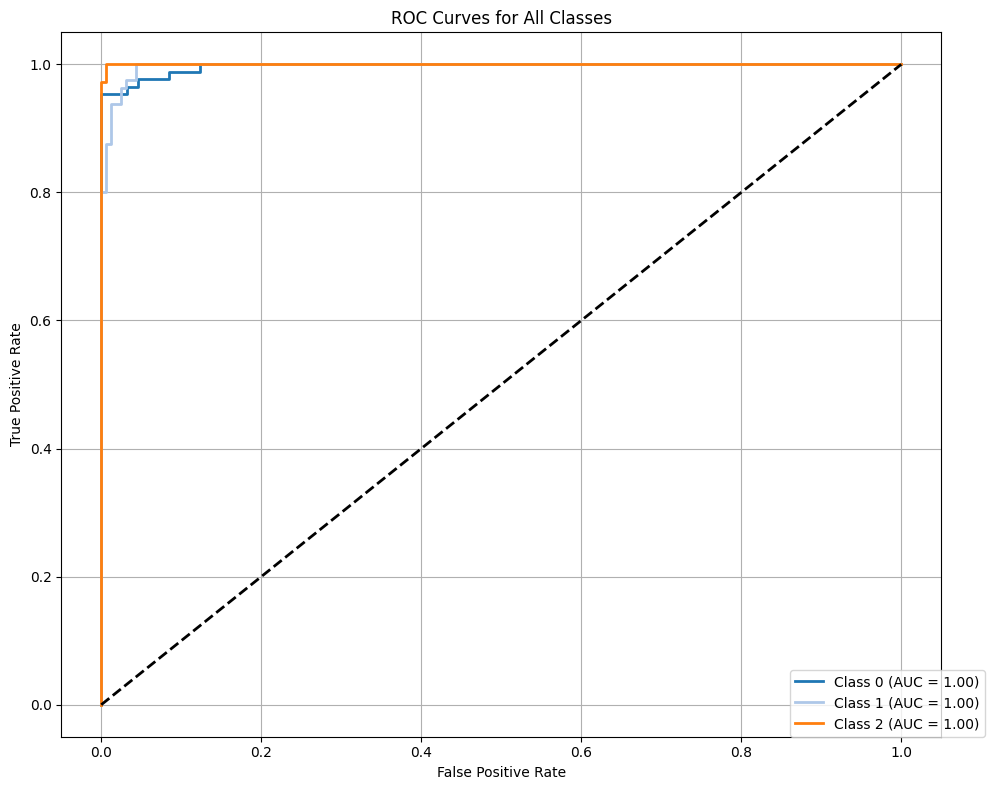

In [44]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Generate 15 unique colors using a colormap
cmap = cm.get_cmap('tab20', 15)  # 'tab20' or 'nipy_spectral' gives good variety

# ------------------------- ROC Curve -------------------------
plt.figure(figsize=(10, 8))

for i in range(len(report_labels)):
    fpr, tpr, _ = roc_curve(true_labels == report_labels[i], probs[:, report_labels[i]])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=cmap(i), lw=2, label=f'Class {report_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


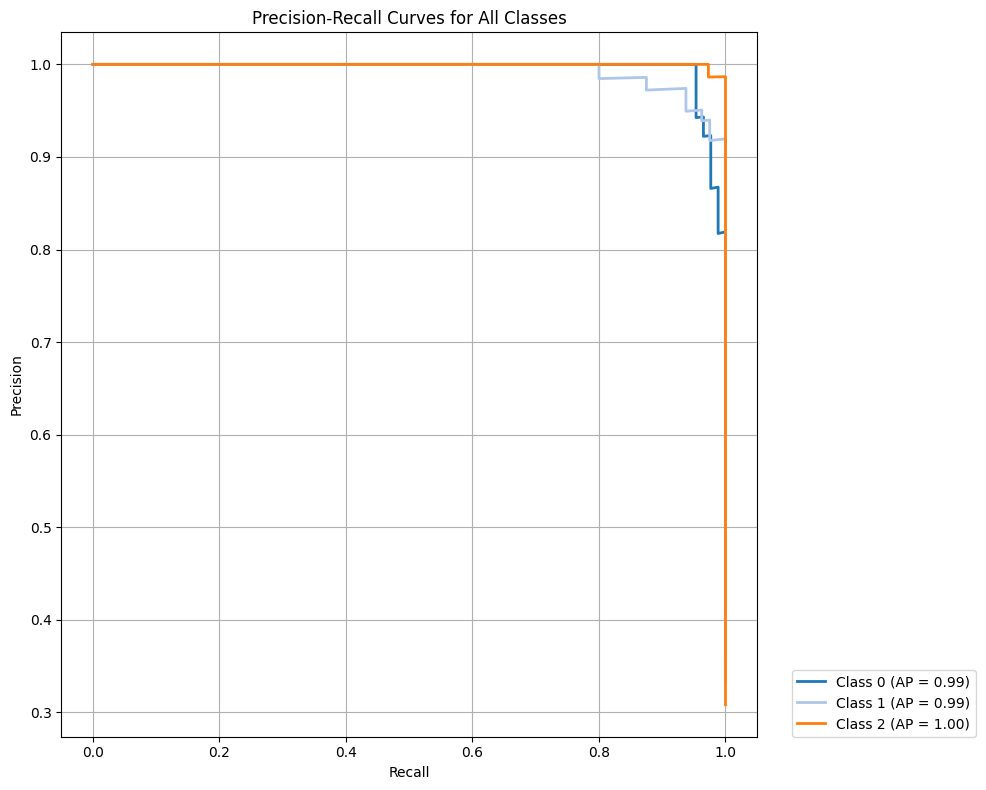

In [45]:

# -------------------- Precision-Recall Curve --------------------
plt.figure(figsize=(10, 8))

for i in range(len(report_labels)):
    precision, recall, _ = precision_recall_curve(true_labels == report_labels[i], probs[:, report_labels[i]])
    avg_prec = average_precision_score(true_labels == report_labels[i], probs[:, report_labels[i]])
    plt.plot(recall, precision, color=cmap(i), lw=2, label=f'Class {report_labels[i]} (AP = {avg_prec:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Classes')
plt.legend(loc="lower left", bbox_to_anchor=(1.05, 0), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()
